In [1]:
#coding=utf-8
# ------------------------------------------------------------------------------------------#
# 
#-------------------------------------------------------------------------------------------#
from netCDF4 import Dataset as ncfile
from netCDF4 import num2date, date2num
import xarray as xr
#import datetime
from datetime import datetime
import os, fnmatch, glob
import numpy as np
import numpy.ma as ma
import math
import matplotlib.dates as dates
from pyproj import Proj, transform
import scipy
from scipy import spatial
import cartopy.crs as ccrs
import cmocean
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

/home/maltem/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [29]:
# Find nearest neighbor point index
def do_kdtree(combined_x_y_arrays,points):
        mytree = scipy.spatial.cKDTree(combined_x_y_arrays)
        dist, indexes = mytree.query(points)
        return indexes
    
# projection of the grid -> era5 on to modis       
def remapfield(MODvar,idx_pos_ij):
    MODprojvar=np.zeros(np.shape(idx_pos_ij))
    for i in range(np.shape(idx_pos_ij)[0]):
        for j in range(np.shape(idx_pos_ij)[1]):
            MODprojvar[i][j]=MODvar[idx_pos_ij[i][j]]
    return MODprojvar

class SpatialEvaluation:
    
    def __init__(self,modeleval):
        self.model=modeleval
    
    def defineGridTransforms(self):
        
        #MODIS grid (same as AROME Arctic)      
        modisin='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/observations/remotesensing/aa-modis-2024.nc'
        AROMEin='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/04/arome_arctic_det_2_5km_20240404T00Z.nc'
        #
        modisdataset = ncfile(modisin, 'r')     
        aromedataset = ncfile(AROMEin, 'r') # not sufficient information in modis file
        modis_lons = aromedataset.variables['longitude'][:,:]
        modis_lats = aromedataset.variables['latitude'][:,:]
        modis_x = aromedataset.variables['x'][:]
        modis_y = aromedataset.variables['y'][:]
        modis_times = modisdataset.variables['time'][:]
        t_unit = modisdataset.variables['time'].units
        modis_nctimes=[]; modis_nctimes.append(num2date(modis_times,units = t_unit,calendar = 'proleptic_gregorian'))
        modis_nctimes=np.squeeze(modis_nctimes)
        modis_nctimenum = np.squeeze(dates.date2num(modis_nctimes))        
        #
        modis_proj = Proj("+proj=lcc +lat_1=77.5 +lat_2=77.5 +lat_0=77.5 +lon_0=-25 +R=6371000")          
        modisdataset.close()
        aromedataset.close()
            
            
        if self.model=='ECMWF-IFS': 
            # ----- IFS Grid information
            fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/ECMWF-IFS/'
            MODin = fc_data_path+'Arctic.ECMWF_extracted_20240401T00Z.nc'
            #
            MODdataset = ncfile(MODin, 'r')
            MOD_lons = MODdataset.variables['lon'][:]
            MOD_lats = MODdataset.variables['lat'][:]
            MOD_times = MODdataset.variables['time'][:]
            t_unit = MODdataset.variables['time'].units
            t_cal = MODdataset.variables['time'].calendar
            MOD_nctimes=[]; MOD_nctimes.append(num2date(MOD_times,units = t_unit,calendar = t_cal))
            MOD_nctimenum = np.squeeze(dates.date2num(MOD_nctimes))
            #
            MOD_proj = Proj(init = 'epsg:4326')
            MODdataset.close()

        if self.model=='ECMWF-AIFS':
            fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/ECMWF-AIFS/'
            MODin = fc_data_path+'Arctic.ECMWF_AIFS_extracted_20240401T00Z.nc'
            #
            MODdataset = ncfile(MODin, 'r')
            MOD_lons = MODdataset.variables['lon'][:]
            MOD_lats = MODdataset.variables['lat'][:]
            MOD_times = MODdataset.variables['time'][:]
            t_unit = MODdataset.variables['time'].units
            t_cal = MODdataset.variables['time'].calendar
            MOD_nctimes=[]; MOD_nctimes.append(num2date(MOD_times,units = t_unit,calendar = t_cal))
            MOD_nctimenum = np.squeeze(dates.date2num(MOD_nctimes))
            #
            MOD_proj = Proj(init = 'epsg:4326')
            MODdataset.close()
            
        MOD_llon, MOD_llat = np.meshgrid(MOD_lons,MOD_lats)
        modis_xx, modis_yy   = np.meshgrid(modis_x, modis_y)

        # Project all on MODIS grid
        MOD_xx,MOD_yy = transform(MOD_proj, modis_proj, MOD_llon, MOD_llat)

        # Vectorize and concatenate the x,y coordinates
        modis_xx_yy = np.dstack([modis_xx.ravel(), modis_yy.ravel()])[0]
        MOD_xx_yy  = np.dstack([MOD_xx.ravel(), MOD_yy.ravel()])[0]

        #idx_pos = do_kdtree(modis_xx_yy, era5_xx_yy)     #Gives a field with dimensions of era5_xx_yy
        idx_pos = do_kdtree( MOD_xx_yy, modis_xx_yy)     #Gives a field with dimensions of modis_xx_yy

        idx_pos_ij = idx_pos.reshape(np.shape(modis_xx))  #Gives a field with dimensions of modis_xx    

        self.idx_pos_ij = idx_pos_ij
        
        self.modis_lons=modis_lons
        self.modis_lats=modis_lats
        self.modis_nctimes=modis_nctimes
        self.modis_nctimenum=modis_nctimenum
        
        
    def ModelTransform(self,filein,timestep,variable):
    
        if self.model=='ECMWF-IFS': 
            fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/ECMWF-IFS/' 
            MODin = fc_data_path+filein
            #
            MODdataset = ncfile(MODin, 'r')
            MODdata    = MODdataset[variable][timestep,:,:]
            MOD_times = MODdataset.variables['time'][:]
            t_unit = MODdataset.variables['time'].units
            t_cal = MODdataset.variables['time'].calendar
            MOD_nctimes=[]; MOD_nctimes.append(num2date(MOD_times,units = t_unit,calendar = t_cal))
            MOD_nctimes   = np.squeeze(MOD_nctimes)
            MOD_nctimenum = np.squeeze(dates.date2num(MOD_nctimes))
            
            
        if self.model=='ECMWF-AIFS':
            fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/ECMWF-AIFS/'
            MODin = fc_data_path+filein
            #
            MODdataset = ncfile(MODin, 'r')
            MODdata    = MODdataset[variable][timestep,:,:]
            MOD_times = MODdataset.variables['time'][:]
            t_unit = MODdataset.variables['time'].units
            t_cal = MODdataset.variables['time'].calendar
            MOD_nctimes=[]; MOD_nctimes.append(num2date(MOD_times,units = t_unit,calendar = t_cal))
            MOD_nctimes   = np.squeeze(MOD_nctimes)
            MOD_nctimenum = np.squeeze(dates.date2num(MOD_nctimes))
               
        MODdataset.close()
               
        self.MODnctimes   = MOD_nctimes[timestep]
        self.MODnctimenum = MOD_nctimenum[timestep]
        self.MODprojdata  = remapfield(MODdata.ravel(),self.idx_pos_ij)
        
    def DefineSICMask(self):
        
        date = self.MODnctimes
        
        # LOAD AMSR2 Sea-Ice Product
        fc_data_path   = '/lustre/storeB/project/fou/hi/oper/barents_eps/archive/obs/'
        file_name_stub = 'barents_icec-obs_%s' #barents_icec-obs_20240415T00Z.nc
        datetime_str = f"{date.year:04d}{date.month:02d}{date.day:02d}"
        file_prename = file_name_stub % datetime_str
        infile_name = glob.glob(fc_data_path + file_prename + '*.nc')
        
        if infile_name:
            
            IceIn = xr.open_mfdataset(infile_name)
            lats = np.array(IceIn['lat'])
            lons = np.array(IceIn['lon'])
            sicn = np.array(IceIn['ice_conc'])
            
            #sicn=np.squeeze(np.where(sicn<0.99,np.nan,sicn))  
            
            self.SIC_mask=np.squeeze(np.flipud(np.squeeze(sicn)))
            IceIn.close()
                  
        
    def RetrieveMODIS(self,masksic):
        print ('--> RetrieveMODIS')
        #MODIS grid (same as AROME Arctic)      
        modisin='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/observations/remotesensing/aa-modis-2024.nc'
    
        modisdataset = ncfile(modisin, 'r')       
        tm = np.argmin(np.abs(self.MODnctimenum-self.modis_nctimenum))
        
        print('   Model date:',self.MODnctimes)
        print('   MODIS date:',self.modis_nctimes[tm])
            
        tempmodis = np.squeeze(modisdataset['modis_sist_lw'][tm,:,:])
        
        tempmodis = ma.filled(tempmodis, fill_value=np.nan)
        
        
        
        
        if masksic:
            print ('   Masking sic < 0.2')
            tempmodis = np.squeeze(np.where(self.SIC_mask<0.01,np.nan,tempmodis.data))
          #  tempmodis = np.squeeze(np.where(self.SIC_mask==np.nan,np.nan,tempmodis.data))
                        
        self.modisdata = tempmodis
        
        modisdataset.close()
        
    def ConditionalEvaluateModel(self,cond,cmin,cmax,cinc):
        
        if cond=='SIC':
            condfield = self.SIC_mask
            bins = np.arange(cmin, cmax + cinc, cinc) 
        
        modfield=self.MODprojdata
        obsfield=self.modisdata
        
        bias_list=[];mse_list=[]
        # Iterate over the bins
        for i in range(len(bins) - 1):
            # Define the condition range
            lower_bound = bins[i]
            upper_bound = bins[i + 1]
        
            # Create a mask for elements within the current condition range
            condition_mask = (condfield >= lower_bound) & (condfield < upper_bound)
        
            # Extract corresponding values from modfield and obsfield
            mod_vals = modfield[condition_mask]
            obs_vals = obsfield[condition_mask]
        
            # Ensure there is data in this range before calculating
            if len(mod_vals) > 0:
                # Calculate the bias and RMSE for this condition range
                bias = np.nanmean(mod_vals - obs_vals)  # Bias: mean(mod - obs)
                mse = np.nanmean((mod_vals - obs_vals) ** 2)  # MSE: mean((mod - obs)^2)
            
                # Append the results
                bias_list.append(bias)
                mse_list.append(mse)
            else:
                # If no data for this condition, append NaN
                bias_list.append(np.nan)
                mse_list.append(np.nan)
    
            # Return the results as a dictionary
        print("bias", bias_list,"mse", mse_list,"bins", bins[:-1])  # To show which bin corresponds to each result
        self.bias = np.array(bias_list)
        self.mse  = np.array(mse_list)     
        self.bins = np.array(bins)


### Do Calculations in the right Order

In [30]:
m1 = SpatialEvaluation(modeleval='ECMWF-IFS')
m1.defineGridTransforms()

m1.ModelTransform(filein = 'Arctic.ECMWF_extracted_20240410T00Z.nc',timestep=27,variable='SKT')

m1.DefineSICMask()
m1.RetrieveMODIS(masksic=True)
m1.ConditionalEvaluateModel(cond='SIC',cmin=0. ,cmax=1.0 ,cinc=0.2)
#m1.EvaluateModel(condional=True,cond1='SIC',cond2='SIT',...)


--> RetrieveMODIS
   Model date: 2024-04-11 03:00:00
   MODIS date: 2024-04-11 03:00:00
   Masking sic < 0.2
bias [6.119215038831184, 5.1904684499343725, 1.805947216789087, 0.8551138971382217, 2.777238305720696] mse [108.61367768795154, 84.87885454306264, 50.62158322157369, 27.077426588662217, 24.09886704825572] bins [0.  0.2 0.4 0.6 0.8]


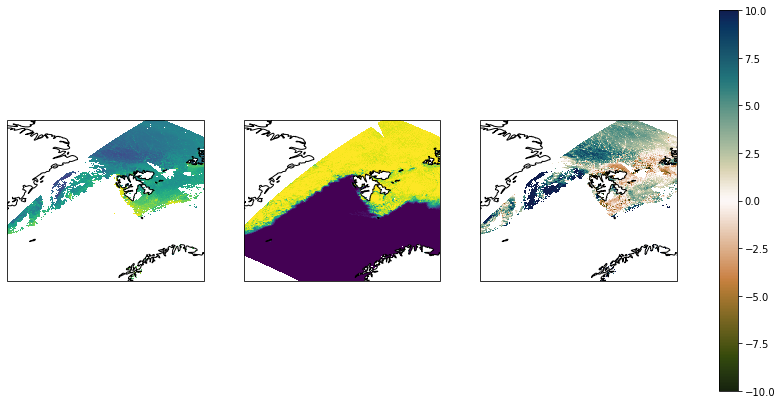

In [31]:
plot_proj = ccrs.Orthographic(14,25)
fig, ax = plt.subplots(figsize=(15, 7),nrows=1,ncols=3,subplot_kw={'projection': plot_proj})

ax[0].coastlines(resolution='50m')
ax[0].set_extent([-10, 30, 67, 88], crs=ccrs.PlateCarree())

contour1 = ax[0].pcolormesh(m1.modis_lons, m1.modis_lats, m1.modisdata, transform=ccrs.PlateCarree())

ax[1].coastlines(resolution='50m')
ax[1].set_extent([-10, 30, 67, 88], crs=ccrs.PlateCarree())

contour1 = ax[1].pcolormesh(m1.modis_lons, m1.modis_lats,  m1.SIC_mask, transform=ccrs.PlateCarree())

ax[2].coastlines(resolution='50m')
ax[2].set_extent([-10, 30, 67, 88], crs=ccrs.PlateCarree())

contour1 = ax[2].pcolormesh(m1.modis_lons, m1.modis_lats, m1.MODprojdata-m1.modisdata , transform=ccrs.PlateCarree(), cmap=cmocean.cm.tarn, vmin=-10,vmax=10)
cbar = fig.colorbar(contour1, ax=ax,location = 'right')

### Loop over many data files:

In [106]:
from datetime import datetime, timedelta

# Define start and end date
start_date = datetime(2024, 4, 11)  # 
end_date = datetime(2024, 4, 18)    # 

# Define timestep and variable
timestep = 27
variable = 'SKT'

# Loop over the days from start to end
current_date = start_date
first=0
while current_date <= end_date:
    # Format the date for the filename (e.g., 20240410)
    formatted_date = current_date.strftime('%Y%m%d')

    for HH in ['00','12']:   
        # Construct the filename
        filein = f'Arctic.ECMWF_extracted_{formatted_date}T{HH}Z.nc'
        print ('Input File: ',filein)
        
        for ti in range(1,14):
    
                # Call the ModelTransform method with the current date's filename
                m1.ModelTransform(filein=filein, timestep=ti, variable=variable)
                m1.DefineSICMask()
                m1.RetrieveMODIS(masksic=True)
                m1.ConditionalEvaluateModel(cond='SIC',cmin=0. ,cmax=1.0 ,cinc=0.2)
                if first==1:
                    bias=m1.bias.reshape(5, 1)
                    mse=m1.mse.reshape(5, 1)
                    first=0
                else:
                    bias=np.hstack((bias,m1.bias.reshape(5, 1)))
                    mse=np.hstack((mse,m1.mse.reshape(5, 1)))
                
            

    # Move to the next day
    current_date += timedelta(days=1)

Input File:  Arctic.ECMWF_extracted_20240411T00Z.nc
--> RetrieveMODIS
   Model date: 2024-04-11 01:00:00
   MODIS date: 2024-04-11 01:00:00
   Masking sic < 0.2
bias [8.215920264795512, 6.3373707738895435, 4.020398941595056, 2.3127724065476487, 2.5207193698194055] mse [207.42482271447565, 128.08837799171565, 89.17519489426282, 47.761849388976984, 18.022183366694346] bins [0.  0.2 0.4 0.6 0.8]
--> RetrieveMODIS
   Model date: 2024-04-11 02:00:00
   MODIS date: 2024-04-11 02:00:00
   Masking sic < 0.2
bias [nan, nan, nan, nan, nan] mse [nan, nan, nan, nan, nan] bins [0.  0.2 0.4 0.6 0.8]
--> RetrieveMODIS
   Model date: 2024-04-11 03:00:00
   MODIS date: 2024-04-11 03:00:00
   Masking sic < 0.2
bias [6.612974784254887, 5.6167455699249365, 1.95638365991827, 0.8588221993685361, 2.7547969795034564] mse [121.38909996802873, 95.02794095325508, 56.4715836281804, 30.09272532323633, 24.492788178349905] bins [0.  0.2 0.4 0.6 0.8]
--> RetrieveMODIS
   Model date: 2024-04-11 04:00:00
   MODIS date:

--> RetrieveMODIS
   Model date: 2024-04-12 01:00:00
   MODIS date: 2024-04-12 01:00:00
   Masking sic < 0.2
bias [nan, nan, nan, nan, nan] mse [nan, nan, nan, nan, nan] bins [0.  0.2 0.4 0.6 0.8]
--> RetrieveMODIS
   Model date: 2024-04-12 02:00:00
   MODIS date: 2024-04-12 02:00:00
   Masking sic < 0.2
bias [4.508467776016086, 1.8563223936283701, -0.350409582802249, -0.22192000946255172, 2.599950369076381] mse [85.76062112925123, 47.20221906546268, 32.239735862678906, 26.053603385493055, 22.10252300943874] bins [0.  0.2 0.4 0.6 0.8]
--> RetrieveMODIS
   Model date: 2024-04-12 03:00:00
   MODIS date: 2024-04-12 03:00:00
   Masking sic < 0.2
bias [7.62954580475965, 2.5062784455741896, -0.0007096387687370498, 0.08514202763085504, 3.11742023109729] mse [150.03277975065362, 65.70209803303833, 43.12494634506495, 31.01960349299644, 30.239179629378082] bins [0.  0.2 0.4 0.6 0.8]
--> RetrieveMODIS
   Model date: 2024-04-12 04:00:00
   MODIS date: 2024-04-12 04:00:00
   Masking sic < 0.2
bias 

--> RetrieveMODIS
   Model date: 2024-04-13 02:00:00
   MODIS date: 2024-04-13 02:00:00
   Masking sic < 0.2
bias [10.317391267815296, 3.997863276138628, 1.3767106440774777, -0.13330487675957103, 4.0669977379757505] mse [336.902374790198, 132.27705490161532, 88.738469763029, 72.62460892071405, 69.15873096824232] bins [0.  0.2 0.4 0.6 0.8]
--> RetrieveMODIS
   Model date: 2024-04-13 03:00:00
   MODIS date: 2024-04-13 03:00:00
   Masking sic < 0.2
bias [8.13707686838741, 7.565281172780229, 5.22612923185634, 3.8181505210989517, 4.873136143036349] mse [183.87434715823787, 128.8257216156839, 74.15368564524589, 40.879889762414, 38.91798269524359] bins [0.  0.2 0.4 0.6 0.8]
--> RetrieveMODIS
   Model date: 2024-04-13 04:00:00
   MODIS date: 2024-04-13 04:00:00
   Masking sic < 0.2
bias [3.4876547186565823, 2.3621384222472757, 0.14740622047861932, -1.4799647341007216, 3.436737694796304] mse [133.68993880803487, 110.06113558874964, 76.84032788716466, 45.18990879284332, 44.662954389337095] bins 

--> RetrieveMODIS
   Model date: 2024-04-14 03:00:00
   MODIS date: 2024-04-14 03:00:00
   Masking sic < 0.2
bias [3.6712787079113234, 4.610729962102364, 2.809185248018949, 0.9948760878837832, 3.266737979293718] mse [91.9278856232759, 120.79825808580387, 92.39488818522295, 51.93927182858574, 33.48193833760828] bins [0.  0.2 0.4 0.6 0.8]
--> RetrieveMODIS
   Model date: 2024-04-14 04:00:00
   MODIS date: 2024-04-14 04:00:00
   Masking sic < 0.2
bias [nan, nan, nan, nan, nan] mse [nan, nan, nan, nan, nan] bins [0.  0.2 0.4 0.6 0.8]
--> RetrieveMODIS
   Model date: 2024-04-14 05:00:00
   MODIS date: 2024-04-14 05:00:00
   Masking sic < 0.2
bias [2.15763975073291, 0.7514411808158546, -1.3149254935782557, -0.6973355311635248, 2.7804972795906333] mse [40.446388291813975, 40.323645005299596, 35.939602788888664, 25.659126078472738, 25.349969015852107] bins [0.  0.2 0.4 0.6 0.8]
--> RetrieveMODIS
   Model date: 2024-04-14 06:00:00
   MODIS date: 2024-04-14 06:00:00
   Masking sic < 0.2
bias [-1

--> RetrieveMODIS
   Model date: 2024-04-15 04:00:00
   MODIS date: 2024-04-15 04:00:00
   Masking sic < 0.2
bias [4.160594224129311, 4.78181120696804, 3.6908830972093116, 2.8902245587891753, 2.6486106548159523] mse [96.61932602188678, 97.81127173862531, 82.62465879693369, 52.046209467399215, 22.013100258453342] bins [0.  0.2 0.4 0.6 0.8]
--> RetrieveMODIS
   Model date: 2024-04-15 05:00:00
   MODIS date: 2024-04-15 05:00:00
   Masking sic < 0.2
bias [-4.045835351968188, -3.4837897445041097, -2.6505601885410064, -0.6352144933748427, 1.8141978710324222] mse [61.3345093070266, 49.394601900724474, 39.14350762109765, 18.693032929726787, 13.623871386265998] bins [0.  0.2 0.4 0.6 0.8]
--> RetrieveMODIS
   Model date: 2024-04-15 06:00:00
   MODIS date: 2024-04-15 06:00:00
   Masking sic < 0.2
bias [10.610053966366754, 8.56875162040675, 6.603158768882998, 5.229320128645747, 3.1637469516473784] mse [122.70028341441639, 92.40562346129678, 71.90636868924732, 56.38772693889536, 22.890683230785864]

--> RetrieveMODIS
   Model date: 2024-04-16 05:00:00
   MODIS date: 2024-04-16 05:00:00
   Masking sic < 0.2
bias [-0.5847462242054201, -0.16453728008590374, -0.7655653436721379, -0.10114492551361545, 2.081249143220291] mse [43.55750245866311, 28.291349043364825, 19.533111964539636, 17.461123658727644, 21.889703941996498] bins [0.  0.2 0.4 0.6 0.8]
--> RetrieveMODIS
   Model date: 2024-04-16 06:00:00
   MODIS date: 2024-04-16 06:00:00
   Masking sic < 0.2
bias [-2.181354306141421, -0.8248016092791864, -0.8197507323318193, -0.12799073520264112, 1.1230030405534404] mse [60.09265469802901, 33.193915244710055, 19.539104288327053, 14.326601653731517, 14.038399344711541] bins [0.  0.2 0.4 0.6 0.8]
--> RetrieveMODIS
   Model date: 2024-04-16 07:00:00
   MODIS date: 2024-04-16 07:00:00
   Masking sic < 0.2
bias [nan, nan, nan, nan, nan] mse [nan, nan, nan, nan, nan] bins [0.  0.2 0.4 0.6 0.8]
--> RetrieveMODIS
   Model date: 2024-04-16 08:00:00
   MODIS date: 2024-04-16 08:00:00
   Masking sic

--> RetrieveMODIS
   Model date: 2024-04-17 06:00:00
   MODIS date: 2024-04-17 06:00:00
   Masking sic < 0.2
bias [nan, nan, nan, nan, nan] mse [nan, nan, nan, nan, nan] bins [0.  0.2 0.4 0.6 0.8]
--> RetrieveMODIS
   Model date: 2024-04-17 07:00:00
   MODIS date: 2024-04-17 07:00:00
   Masking sic < 0.2
bias [-0.09560347038805515, -0.16627848735536369, -0.09935992194776541, -0.08586982186203992, 1.165610303568166] mse [11.13196097972631, 17.281809437701206, 13.514779208325244, 11.369272363161677, 13.351966961130957] bins [0.  0.2 0.4 0.6 0.8]
--> RetrieveMODIS
   Model date: 2024-04-17 08:00:00
   MODIS date: 2024-04-17 08:00:00
   Masking sic < 0.2
bias [-0.16170756425103697, -0.39553627514601886, -0.3315401279144551, -0.43056276115129416, 0.8335043490936832] mse [7.625483003631632, 14.252930500927153, 11.981831963841453, 10.912053316059481, 12.6111104993166] bins [0.  0.2 0.4 0.6 0.8]
--> RetrieveMODIS
   Model date: 2024-04-17 09:00:00
   MODIS date: 2024-04-17 09:00:00
   Masking 

--> RetrieveMODIS
   Model date: 2024-04-18 07:00:00
   MODIS date: 2024-04-18 07:00:00
   Masking sic < 0.2
bias [0.6625230440286238, 0.5422600904243146, 0.3202463046469266, -0.49273012373838243, -3.0496071393862194] mse [1.1482983271524785, 1.9140340914786973, 5.5426082713839655, 4.425320444787934, 13.16675573625578] bins [0.  0.2 0.4 0.6 0.8]
--> RetrieveMODIS
   Model date: 2024-04-18 08:00:00
   MODIS date: 2024-04-18 08:00:00
   Masking sic < 0.2
bias [0.6797805559615028, -0.6770971962160138, 0.03646295093321454, -0.19182888840452228, 0.8970754897973602] mse [15.070744544514556, 23.278264851921467, 15.792438431959885, 10.053605845790571, 11.366284963355] bins [0.  0.2 0.4 0.6 0.8]
--> RetrieveMODIS
   Model date: 2024-04-18 09:00:00
   MODIS date: 2024-04-18 09:00:00
   Masking sic < 0.2
bias [1.6783439686123895, 2.580940565030147, 3.7262356436802913, 0.6439397785807492, 0.6321263750642426] mse [23.905401444605822, 48.75485844696267, 54.76747146480681, 23.63059921331736, 14.32541

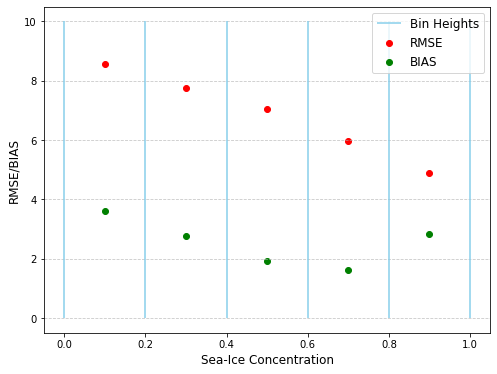

In [107]:
rmse_values = np.sqrt(np.nanmean(mse,axis=1))
bias_values = np.nanmean(bias,axis=1)

bins = np.arange(0.0, 1.2, 0.2) 
bin_midpoint = bins[0:5]+0.1
plt.figure(figsize=(8, 6))
plt.vlines(bins, ymin=0, ymax=10, colors='skyblue', linestyles='solid', label="Bin Heights")
plt.scatter(bin_midpoint,rmse_values,color='red', label='RMSE')
plt.scatter(bin_midpoint,bias_values,color='green', label='BIAS')

plt.xlabel("Sea-Ice Concentration", fontsize=12)
plt.ylabel("RMSE/BIAS", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()